##### Silver Speech and Golden Silnce: Spoiler Detection Project

## Train-Test-Split and Preprocessing 

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from datetime import datetime
from tqdm import tqdm

In [2]:
#Disable scientific notation for floats
pd.options.display.float_format = '{:,}'.format

#Enable viewing more (in this case: all) features of a dataset
pd.set_option('display.max_columns', 500)

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Load datafile
df = pd.read_hdf('/Volumes/My Passport OSX/NF_Capstone_Spoiler_Detection/data/complete_data.h5')

### Train-Test-Split

In [5]:
# Split train, validation and test test with ratios 70% - 20% -10%
train, validation, test = np.split(df.sample(frac=1), [int(.7*len(df)), int(.9*len(df))])

In [ ]:
#Save validation and test sets (train set will be saved after preprocessing) as HDF5
test.to_hdf('data/test_data.h5', key = 'test')
validation.to_hdf('data/validation_data.h5', key = 'validation')

### Data Preprocessing

From now on, only the train data is manipulated, validation and test sets are only worked on just before model evaluation.

In [6]:
#Reset the index
train = train.reset_index()

In [7]:
#Drop the feature containing the old index
train.drop('index', axis = 1, inplace = True)

In [8]:
#Information on data types and missing values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 964623 entries, 0 to 964622
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            964623 non-null  object
 1   time               964623 non-null  object
 2   review             964623 non-null  object
 3   rating             964623 non-null  int64 
 4   spoiler            964623 non-null  bool  
 5   book_id            964623 non-null  object
 6   review_id          964623 non-null  object
 7   genres             964623 non-null  object
 8   title              964623 non-null  object
 9   description        964623 non-null  object
 10  publication_year   964623 non-null  object
 11  publication_month  964623 non-null  object
 12  publication_day    964623 non-null  object
 13  average_rating     964623 non-null  object
 14  ratings_count      964623 non-null  object
 15  num_pages          964623 non-null  object
dtypes: bool(1), int64(1)

In [9]:
#Show unique values in the sorted genres column. Since the genres column contains dictionaries, 
#the data type is temporarily changed to string format. 
values = train.genres.astype('str').sort_values(ascending = False)
values

286734    {'young-adult': 998, 'fantasy, paranormal': 13...
415870    {'young-adult': 998, 'fantasy, paranormal': 13...
885890    {'young-adult': 998, 'fantasy, paranormal': 13...
693516    {'young-adult': 998, 'fantasy, paranormal': 13...
524661    {'young-adult': 998, 'fantasy, paranormal': 13...
                                ...                        
311005                      {'children': 102, 'fiction': 7}
321268                      {'children': 102, 'fiction': 7}
661513                      {'children': 102, 'fiction': 7}
703712                      {'children': 102, 'fiction': 7}
395275                      {'children': 102, 'fiction': 7}
Name: genres, Length: 964623, dtype: object

#### Change data and data types

Obviously, some changes are necessary:
* Missing values are denoted as '' or '[]', respectively, and need to be changed to np.nan
* Datatypes need to be changed for some variables:
  * _time_ to date
  * _book_id_ to string
  * _publication_year_, _publication_month_, _publication_day_, _average_rating_, _ratings_count_, _num_pages_ to numeric

#### Change data types

In [10]:
#Function for adaption of datatypes
def change_dtypes(df, features_list):
    
    """df: pd.DataFrame
    features list (mind the sequence!):'book_id', 'time', 'average_rating', 'ratings_count', 'publication_year', 
    'publication_month', 'publication_day'"""
    
    df[features_list[0]]  =  df[features_list[0]].astype('str')
    
    from datetime import datetime
    df[features_list[1]] = pd.to_datetime(df[features_list[1]])
    
    for col in df[features_list[2:]]:
        df[col] = pd.to_numeric(df[col], errors = 'coerce')

In [11]:
#List of features to be changed 
change_features = ['book_id', 'time', 'average_rating', 'ratings_count', 'publication_year', 'publication_month', 'publication_day', 'num_pages']

In [12]:
change_dtypes(train, change_features)

#### Feature Engineering

In [13]:
def new_features(df):
    #Add a new feature containing the frequency-weighted average of book ratings.
    df['weighted_avg_rating'] = df.average_rating * df.ratings_count
    
    #Create a new column containing the genre most frequently allocated.
    #Define function fetching the most frequent (= value) genre (= key)
    import operator

    def get_genre(dic):

        ''' Return the key of the highest value of dictionary given in.
        If the dictionary is empty, return np.nan
        '''

        try:
            x = max(dic.items(), key = operator.itemgetter(1))[0]
            return x
        except:
            return np.nan  
    genre = []
    for i in range(len(df)):
        a = get_genre(df.genres[i])
        genre.append(a)
    df['genre'] = pd.Series(genre)
    
    #Create column with overall spoiler labels coded as 0 = "no spoiler" and 1 = "spoiler".
    df['spoiler_dum'] = np.where(df['spoiler']== False, 0, 1)
    
    #Get only the labels 0 and 1 from the review
    def get_labels(x):
        return [label for label, text in x]
    #Get only the text from the review
    def get_text(x):
        return [text for label, text in x]
    # sentence-wise labels and review text without labels by applying the function defined above.
    #Apply the function to the data
    df['sentence_labels'] =df.review.apply(lambda x: get_labels(x))
    df['review_texts'] = df.review.apply(lambda x: get_text(x))
    
    #Get a variable with the number of sentences per review
    df['review_length'] = pd.Series()
    for i in range(len(df)):
        df['review_length'][i] = len(df['review'][i])

In [14]:
new_features(train)

#### Missing values

In [15]:
#Denote missing values as np.nan instead of ''.  
train.replace('', np.nan, inplace = True)

In [16]:
# We want to see how many missing values are in every column (as relative frequencies): 
for col in train.columns:
    pct_missing = np.mean(train[col].isna())
    print('{} - {}%'.format(col, round(pct_missing*100, 2)))

user_id - 0.0%
time - 0.0%
review - 0.0%
rating - 0.0%
spoiler - 0.0%
book_id - 0.0%
review_id - 0.0%
genres - 0.0%
title - 0.0%
description - 0.51%
publication_year - 9.91%
publication_month - 11.71%
publication_day - 13.62%
average_rating - 0.0%
ratings_count - 0.0%
num_pages - 3.69%
weighted_avg_rating - 0.0%
genre - 0.0%
spoiler_dum - 0.0%
sentence_labels - 0.0%
review_texts - 0.0%
review_length - 0.0%


Publication year, month and day also contain missing values. We drop month and day features as well as the rows with missing values for the publication year.
Missing values for num_pages are also dropped.

This means a reduction of the train set by 12.3%. Since all features containing NaNs are not of major importance, the reduced dataset is stored separately and will be used only when needed.

In [17]:
#Copy the original train set
train_red = train.copy()

In [18]:
# Drop the columns and rows not needed in the copied dataframe
train_red.drop(columns = ['publication_month', 'publication_day'], axis = 1, inplace = True)
train_red.dropna(subset = ['publication_year', 'num_pages', 'description'], inplace = True)

#### Outliers

We explore boxplots of numeric features for outlier detection.

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 964623 entries, 0 to 964622
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   user_id              964623 non-null  object        
 1   time                 964623 non-null  datetime64[ns]
 2   review               964623 non-null  object        
 3   rating               964623 non-null  int64         
 4   spoiler              964623 non-null  bool          
 5   book_id              964623 non-null  object        
 6   review_id            964623 non-null  object        
 7   genres               964623 non-null  object        
 8   title                964623 non-null  object        
 9   description          959665 non-null  object        
 10  publication_year     869018 non-null  float64       
 11  publication_month    851709 non-null  float64       
 12  publication_day      833251 non-null  float64       
 13  average_rating

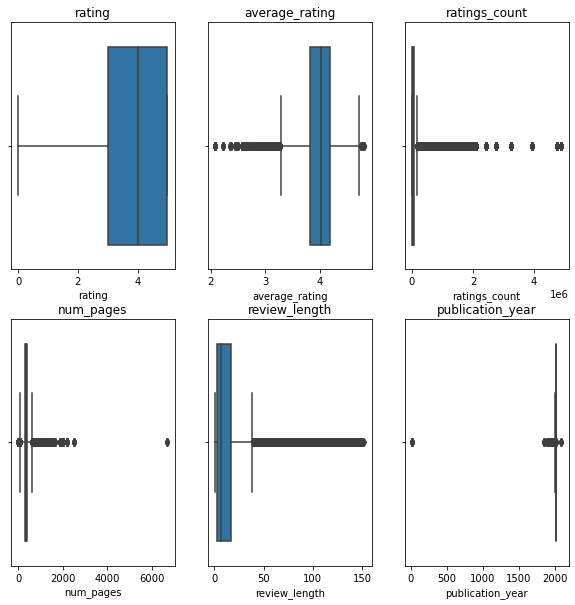

In [20]:
plot = [train.rating, train.average_rating, train.ratings_count, train.num_pages, train.review_length, train.publication_year]
plt.figure(figsize = (10,10))
for i in range(len(plot)):
    plt.subplot(2,3, i+1)
    sns.boxplot(x = plot[i])
    plt.title(plot[i].name)

Generally, outliers play only a minor role for our project: our main subject is the classification of reviews with regard to spoilers, which might be modulated by other features (we will learn about that in the EDA) but we're only secondarily intersted in these interactions. Therefore, outliers will not be removed from the dataframe but we will account for them in the feature standardization. 

To look for unusual values, let's have a look at the descriptives:

In [21]:
#Descriptives of non-numeric features
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rating,"964,623.0",3.6850396476136273,1.2524803772009327,0.0,3.0,4.0,5.0,5.0
publication_year,"869,018.0","2,011.0783677668358",10.207363070736111,16.0,"2,010.0","2,012.0","2,014.0","2,089.0"
publication_month,"851,709.0",6.290296333606901,3.2615405438759715,1.0,4.0,6.0,9.0,12.0
publication_day,"833,251.0",14.038079762280514,9.808361253027586,1.0,5.0,13.0,24.0,31.0
average_rating,"964,623.0",4.002129350014754,0.2714696682977209,2.08,3.83,4.02,4.19,4.82
ratings_count,"964,623.0","123,988.71320401857","393,387.46541047556",17.0,"4,170.0","16,354.0","69,960.0","4,899,965.0"
num_pages,"929,072.0",357.87322511064804,145.70543527438335,0.0,287.0,346.0,416.0,"6,680.0"
weighted_avg_rating,"964,623.0","509,364.04872575693","1,648,911.0553811854",65.96,"16,382.25","65,702.88","285,316.38","21,265,848.099999998"
spoiler_dum,"964,623.0",0.06499430347399969,0.2465159365827804,0.0,0.0,0.0,0.0,1.0
review_length,"964,623.0",12.812757937556952,14.858272032207278,1.0,3.0,7.0,17.0,152.0


In [22]:
train.query('publication_year > 2020')

,user_id,time,review,rating,spoiler,book_id,review_id,genres,title,description,publication_year,publication_month,publication_day,average_rating,ratings_count,num_pages,weighted_avg_rating,genre,spoiler_dum,sentence_labels,review_texts,review_length
22408,97f0f62cc25609896ed46afa1919f102,2017-07-26,"[[0, When is the book coming out?], [0, When t...",0,False,6382055,d77a90323055009dd974eca0326ed15a,"{'fantasy, paranormal': 982, 'fiction': 196, '...","A Dream of Spring (A Song of Ice and Fire, #7)","Originally titled ""A Time For Wolves"". The sev...","2,021.0",nan,nan,4.41,914,nan,"4,030.7400000000002","fantasy, paranormal",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[When is the book coming out?, When the sun ri...",12.0
70782,2379b71a22fc6fc92c79b3b0fe0a60c5,2014-01-07,"[[0, 10/14/12 I'm just going to go ahead and a...",0,False,6382055,ea5ce53b86bf075d95a82e69473d2308,"{'fantasy, paranormal': 982, 'fiction': 196, '...","A Dream of Spring (A Song of Ice and Fire, #7)","Originally titled ""A Time For Wolves"". The sev...","2,021.0",nan,nan,4.41,914,nan,"4,030.7400000000002","fantasy, paranormal",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",[10/14/12 I'm just going to go ahead and assum...,13.0
160872,31c85fc6bf4ed80533c3212fc88b8386,2014-01-06,"[[0, Will I be teleporting to pick this one up...",0,False,6382055,8596fd4ec8b209d96c1d639c4972db5a,"{'fantasy, paranormal': 982, 'fiction': 196, '...","A Dream of Spring (A Song of Ice and Fire, #7)","Originally titled ""A Time For Wolves"". The sev...","2,021.0",nan,nan,4.41,914,nan,"4,030.7400000000002","fantasy, paranormal",0,[0],[Will I be teleporting to pick this one up or ...,1.0
202575,4672eb229c808b792b8ea95f01f19784,2012-12-24,"[[0, 2020..DAFUQ?], [0, I'll have graduated co...",0,False,6382055,777e018ee83d4e010bb9df05f9f58c5f,"{'fantasy, paranormal': 982, 'fiction': 196, '...","A Dream of Spring (A Song of Ice and Fire, #7)","Originally titled ""A Time For Wolves"". The sev...","2,021.0",nan,nan,4.41,914,nan,"4,030.7400000000002","fantasy, paranormal",0,"[0, 0]","[2020..DAFUQ?, I'll have graduated college by ...",2.0
217002,76277106d0b8de237422d31458ebd383,2017-05-29,"[[1, this is both a hopeful and a not-hopeful ...",0,True,6382055,7d4d02562c378c6274f46eddcbe9f16f,"{'fantasy, paranormal': 982, 'fiction': 196, '...","A Dream of Spring (A Song of Ice and Fire, #7)","Originally titled ""A Time For Wolves"". The sev...","2,021.0",nan,nan,4.41,914,nan,"4,030.7400000000002","fantasy, paranormal",1,[1],[this is both a hopeful and a not-hopeful titl...,1.0
255129,92de18f3a06b499b1bf6d2157b22b3ca,2015-04-11,"[[0, I have no idea when this book will be out...",0,False,6382055,9fac6b58270a11583e5539c5c919e95b,"{'fantasy, paranormal': 982, 'fiction': 196, '...","A Dream of Spring (A Song of Ice and Fire, #7)","Originally titled ""A Time For Wolves"". The sev...","2,021.0",nan,nan,4.41,914,nan,"4,030.7400000000002","fantasy, paranormal",0,[0],[I have no idea when this book will be out--sa...,1.0
322550,6b3f929609c9d97628807d13b59b0b22,2013-01-27,"[[0, I want to start off by saying that I real...",4,False,13638436,012ba26dbc7d2a8dc1da45edba8fe62b,"{'young-adult': 39, 'fiction': 55, 'history, h...","Showtime (Marvelle Circus, #1)",Nope.,"2,089.0",9.0,21.0,3.58,198,2.0,708.84,fiction,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[I want to start off by saying that I really e...,25.0
414484,0e68b8e2a2bd7bd6874ef96ae720f299,2012-12-28,"[[0, 3.5 STARS], [0, Upon reading the summary ...",3,False,13638436,50fa04c1748b23a46c7decbdc26817a1,"{'young-adult': 39, 'fiction': 55, 'history, h...","Showtime (Marvelle Circus, #1)",Nope.,"2,089.0",9.0,21.0,3.58,198,2.0,708.84,fiction,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3.5 STARS, Upon reading the summary of the bo...",31.0
447917,fc091cb7f8dab2ab83bf9784d1fc0853,2016-03-18,"[[0, not diggin the cover :/]]",0,False,6382055,0b883463849c4223f48a4d0fc3573b68,"{'fantasy, paranormal': 982, 'fiction': 196, '...","A Dream of Spring (A Song of 

Publication year: maximum is not a possible value. Looking for the corresponding titles with publication years > 2020, we learn that there are some reviews for the final GoT Series 7, which hasn't been published yet. The corresponding entries are dropped.
The other title with an impossible publication date was actually published in 2012, so the value is changed.
The minimum values for publication year are also errorous. The corresponding book was published in 2016, so the value is changed.

Number of pages: Also, the minimum number of pages is null which is impossible. Respective values are changed to their true values.
There still remain over 2000 entries with values < 100 pages. Although this seems legit for children's books, respective entries are dropped from the datatset if they do not belong to the children genre. 

In [23]:
#Drop entries for last GoT volume.
train.drop(train.loc[train.title == 'A Dream of Spring (A Song of Ice and Fire, #7)'].index, inplace = True)

In [24]:
#Change values from 2089 to 2012 
train.publication_year.replace(2089, 2012, inplace = True)

In [25]:
train.query('publication_year < 1000')

,user_id,time,review,rating,spoiler,book_id,review_id,genres,title,description,publication_year,publication_month,publication_day,average_rating,ratings_count,num_pages,weighted_avg_rating,genre,spoiler_dum,sentence_labels,review_texts,review_length
57004,a69e396bd8cfa86492b3fd29ba2e69a4,2016-05-23,"[[0, I think Lili Valente can do ANYTHING.], [...",5,False,28385237,77046a964660495b98ca589c9500b052,"{'romance': 115, 'fiction': 6}","Magnificent Bastard (Sexy Flirty Dirty, #1)","F*ck Prince Charming. Sometimes, you need a Ma...",16.0,4.0,25.0,4.1,1808,252.0,"7,412.799999999999",romance,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[I think Lili Valente can do ANYTHING., She ca...",21.0
183772,0cb2a295f295b9cb654b8fd31f0d90c5,2017-05-16,"[[0, Fun and cute read, but the ending was a b...",4,False,28385237,b8efd0da0c99d4cc147e2e11d305ffb7,"{'romance': 115, 'fiction': 6}","Magnificent Bastard (Sexy Flirty Dirty, #1)","F*ck Prince Charming. Sometimes, you need a Ma...",16.0,4.0,25.0,4.1,1808,252.0,"7,412.799999999999",romance,0,"[0, 0]","[Fun and cute read, but the ending was a bit o...",2.0
222223,c33c1c28141f5d786c2302e29cfeb348,2016-05-26,"[[0, 4.5 stars for Magnificent Bastard!], [0, ...",5,False,28385237,515246ad2afea104798e17700e20d9da,"{'romance': 115, 'fiction': 6}","Magnificent Bastard (Sexy Flirty Dirty, #1)","F*ck Prince Charming. Sometimes, you need a Ma...",16.0,4.0,25.0,4.1,1808,252.0,"7,412.799999999999",romance,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[4.5 stars for Magnificent Bastard!, (consider...",29.0
278512,c434b8f9592dec15134e6b12293bcb4f,2016-08-11,"[[0, * 5 STARS *], [0, Another new author [to ...",5,False,28385237,9c6047dafb13c3e907d4573a75ce58aa,"{'romance': 115, 'fiction': 6}","Magnificent Bastard (Sexy Flirty Dirty, #1)","F*ck Prince Charming. Sometimes, you need a Ma...",16.0,4.0,25.0,4.1,1808,252.0,"7,412.799999999999",romance,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[* 5 STARS *, Another new author [to me] and a...",12.0
386078,0c2511284f1a56239d879d5f29dc95a9,2016-12-15,"[[0, Told primarily from a male POV, this is a...",4,False,28385237,04f9989d424a54ef78b14ff365cba498,"{'romance': 115, 'fiction': 6}","Magnificent Bastard (Sexy Flirty Dirty, #1)","F*ck Prince Charming. Sometimes, you need a Ma...",16.0,4.0,25.0,4.1,1808,252.0,"7,412.799999999999",romance,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Told primarily from a male POV, this is a pre...",22.0
391701,fad17f3a242dd23512d51ec6330abf14,2016-04-18,"[[0, Full review to come but I loved this book...",4,False,28385237,87a540bba5bb87091fb4c4a4e353c726,"{'romance': 115, 'fiction': 6}","Magnificent Bastard (Sexy Flirty Dirty, #1)","F*ck Prince Charming. Sometimes, you need a Ma...",16.0,4.0,25.0,4.1,1808,252.0,"7,412.799999999999",romance,0,"[0, 0, 0]","[Full review to come but I loved this book!, B...",3.0
410018,97c646801b58ef7529499c03b631c50f,2016-12-20,"[[0, Cute read!!], [0, A good friends to lover...",4,False,28385237,fc05cb6674c459dbfa687f000532f835,"{'romance': 115, 'fiction': 6}","Magnificent Bastard (Sexy Flirty Dirty, #1)","F*ck Prince Charming. Sometimes, you need a Ma...",16.0,4.0,25.0,4.1,1808,252.0,"7,412.799999999999",romance,0,"[0, 0]","[Cute read!!, A good friends to lovers story.]",2.0
466667,b56661124d31552f8ea317746b99c3b2,2017-05-05,"[[0, But why let a break-up end in tears when ...",4,False,28385237,0069096387387f8295221791b9e2c27c,"{'romance': 115, 'fiction': 6}","Magnificent Bastard (Sexy Flirty Dirty, #1)","F*ck Prince Charming. Sometimes, you need a Ma...",16.0,4.0,25.0,4.1,1808,252.0,"7,412.799999999999",romance,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",[But why let a break-up end in tears when it c...,14.0
483253,01546af41b83c0b4141b11c19e8c35af,2016-04-26,"[[0, The characters in this book were wonderfu...",4,False,28385237,d34670c070d9ae7e73b4065c86587f2b,"{'romance': 115, 'fiction': 6}","Magnificent Bastard (Sexy Flirty Dirty, #1)","F*ck Prince Charming. Sometimes, you need a Ma..

In [26]:
#Change values from 16 to 2016 
train.publication_year.replace(16, 2016, inplace = True)

In [27]:
train.query('num_pages == 0')

,user_id,time,review,rating,spoiler,book_id,review_id,genres,title,description,publication_year,publication_month,publication_day,average_rating,ratings_count,num_pages,weighted_avg_rating,genre,spoiler_dum,sentence_labels,review_texts,review_length
49234,bb5e8af6b4053bafd7feff7199ada51c,2013-07-11,"[[0, Prior to listening to this audiobook, I'd...",3,False,12862980,eeb510abbb617cf078693fb574280d51,"{'fantasy, paranormal': 3113, 'young-adult': 1...","The False Prince (The Ascendance Trilogy, #1)",The False Princeis the thrilling first audiobo...,"2,012.0",4.0,1.0,4.23,182,0.0,769.8600000000001,"fantasy, paranormal",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Prior to listening to this audiobook, I'd not...",22.0
64733,e14e38a7762fe365c473896611c39391,2014-04-09,"[[0, First, though I started to suspect what i...",5,False,12862980,27e57f72bf3ff7487ea9a68b2a4b3669,"{'fantasy, paranormal': 3113, 'young-adult': 1...","The False Prince (The Ascendance Trilogy, #1)",The False Princeis the thrilling first audiobo...,"2,012.0",4.0,1.0,4.23,182,0.0,769.8600000000001,"fantasy, paranormal",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[First, though I started to suspect what is go...",11.0
109492,6079cf8b963518fdf7539a289e72e5b6,2012-08-21,"[[0, Despite the two downfalls of (1) a cover ...",5,False,12862980,0bf7de832e4cb88aba4a3fd236428958,"{'fantasy, paranormal': 3113, 'young-adult': 1...","The False Prince (The Ascendance Trilogy, #1)",The False Princeis the thrilling first audiobo...,"2,012.0",4.0,1.0,4.23,182,0.0,769.8600000000001,"fantasy, paranormal",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",[Despite the two downfalls of (1) a cover that...,14.0
120908,918df7a96257c3127ddf7349a99c0f5e,2017-08-03,"[[0, First off I want to say that Erin Morgens...",2,False,12606483,8aefd031a18a3111333ed508f5ef0d23,"{'fantasy, paranormal': 13775, 'fiction': 8326...",The Night Circus,The circus arrives without warning. No announc...,"2,011.0",9.0,13.0,4.03,709,0.0,"2,857.27","fantasy, paranormal",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[First off I want to say that Erin Morgenstern...,20.0
138825,c78a77b31c53e025b19bd0c46ad468d5,2014-08-24,"[[0, Pathfinder was a good story.], [0, Ruins ...",0,False,10148930,f91d4a0e30418414501466cc8403f440,"{'fantasy, paranormal': 99, 'fiction': 85, 'yo...","Ruins (Pathfinder, #2)",When Rigg and his friends crossed the Wall bet...,"2,012.0",10.0,30.0,3.87,6884,0.0,"26,641.08","fantasy, paranormal",0,"[0, 0, 0]","[Pathfinder was a good story., Ruins felt like...",3.0
142536,76fae60a6ecb7c0188928b14cd0e8e7f,2012-11-02,"[[0, I liked the images conjured by Morgenster...",3,False,12606483,71456ee449e7c853bd02e5c7f4c38e2f,"{'fantasy, paranormal': 13775, 'fiction': 8326...",The Night Circus,The circus arrives without warning. No announc...,"2,011.0",9.0,13.0,4.03,709,0.0,"2,857.27","fantasy, paranormal",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",[I liked the images conjured by Morgenstern fo...,15.0
153652,d37e71f2ad14fa99dcc0b8ed0b5dbfe3,2012-08-22,"[[0, I had not seen the movie when I listened ...",4,False,8081450,d62561eaa77f18618832dbff211681a1,"{'fiction': 1172, 'history, historical fiction...","War Horse (War Horse, #1)","A powerful tale of war, redemption, and a hero...","2,010.0",9.0,1.0,4.13,116,0.0,479.08,fiction,0,"[0, 0, 0, 0, 0]",[I had not seen the movie when I listened to t...,5.0
167983,a7622a4ac51538b2727a2512f23b3e2f,2012-09-13,"[[0, Albert's father aquires a beautiful horse...",4,False,8081450,859d95a72fbdae6e4a3248ad0b1a1be6,"{'fiction': 1172, 'history, historical fiction...","War Horse (War Horse, #1)","A powerful tale of war, redemption, and a hero...","2,010.0",9.0,1.0,4.13,116,0.0,479.08,fiction,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Albert's father aquires a beautiful horse., A...",22.0
184797,ba96a4a928fb60fa0bf4c938ead19977,2013-01-01,"[[0, Are we human?], [0, Or are we facemask?],...",3,False,10148930,73409634eacea235ebdf45aae6ad286a,"{'fantasy, parano

In [28]:
#Change values of num_pages for titles with num_pages == 0
train.num_pages = np.where(train.title == 'Ruins (Pathfinder, #2)', 544, train.num_pages)
train.num_pages = np.where(train.title == 'The False Prince (The Ascendance Trilogy, #1)', 342, train.num_pages)
train.num_pages = np.where(train.title == 'The Night Circus', 400, train.num_pages)
train.num_pages = np.where(train.title == 'War Horse (War Horse, #1)', 165, train.num_pages)

In [ ]:
#Safe the reduced dataframe as HDF5
train_red.to_json('data/train_reduced.json')

In [ ]:
#Save the not reduced dataframe as json (HDF5 is not possible for values too large to convert)
train.to_json('data/train_data.json')